In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import torch
import torchaudio 
from torchaudio import transforms
from torch.utils.data import random_split
from IPython.display import Audio

In [2]:
from classifier.audioutils import AudioUtils
from classifier.sounddataset import SoundDataset
from classifier.audioclassifier import AudioClassifier
import train

In [3]:
# Load audio input data into map

'''
Note the directory structure is assumed to be of the following form:

audio_input/
    /training/
        00_bass_drum/
            BD1.wav
            BD2.wav
        01_snare_drum/
            SN1.wav
            SN2.wav
        ...
        ...
        05_rim/
            rim1.wav
            rim2.wav
        ...
        ...
        09_cymbal/
            cymbal1.wav
            cymbal2.wav
    /test/
        ...

The subdirectories for each type of sound need to begin with a number as this will
be extracted and used as the label for the sound class
'''

# NOTE: Assumes all samples are of the sample sample rate - if this is not the case add a method to AudioUtils to convert to 44100 (or whatever!)

CURRENT_DIR = os.getcwd()
TRAIN_DIR = os.path.join(CURRENT_DIR, "audio/training")

# Scan AUDIO_DIR and load all filenames into a map with key - path, value - label (1-10, 1. kick, 2. snare, ... 10.cymbal)

audio_datas = []
for subdir, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        if os.path.splitext(file)[-1] == ".wav":
            # get label for subdir
            label = int(os.path.split(subdir)[-1].split("_")[0])
            path = os.path.join(subdir, file)
            audio_datas.append((path, label))

print("Number of input files: ", len(audio_datas))

Number of input files:  2244


In [4]:
# Calculate the average length and use this to pad or truncate audio files to all be the same size
max_length = 0
lengths = []
for audio_data in audio_datas:
    sig, sr = AudioUtils.open(audio_data[0])
    max_length = max(max_length, sig.shape[1])
    lengths.append(sig.shape[1])

average_length = sum(lengths) / len(audio_datas)
desired_sample_len = int(average_length)

print("Max Length:", max_length, "Average Length:", average_length, "Sample Size:", desired_sample_len)


Max Length: 341501 Average Length: 20734.03787878788 Sample Size: 20734


In [5]:
# Create SoundDataset
audio_dataset = SoundDataset(audio_datas, 1, desired_sample_len)

# Random split 80:20 between training and validation
num_items = len(audio_dataset)
num_train = round(num_items * 0.8)
num_validate = num_items - num_train
train_ds, val_ds = random_split(audio_dataset, [num_train, num_validate])

# Create data loaders for training and validation
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
validation_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


torch.Size([16, 1, 64, 162])
torch.Size([16])


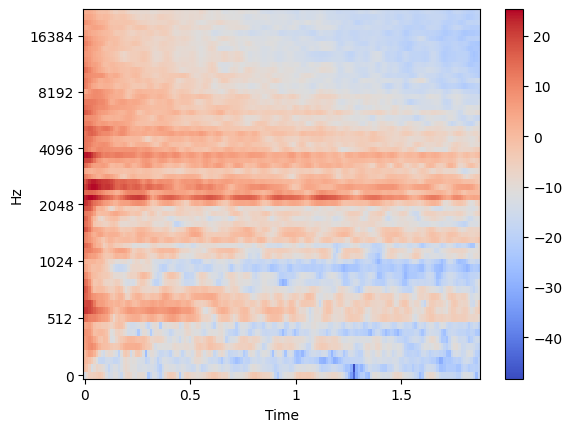

In [6]:
# Visualise the mel spectrogram of one entry

it = iter(train_dl)
first = next(it)

print(first[0].shape)
print(first[1].shape)

spec = transforms.AmplitudeToDB(top_db=80)(first[0][0][0])

plt.figure()
librosa.display.specshow(spec.cpu().numpy(), sr=sr, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show()

In [7]:
# Create Model

model = AudioClassifier()
device = "cpu"
model.to(device)
model.train()

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=10, bias=True)
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, mome

In [8]:
# Train
train.training(model, train_dl, 50)

[1,     1] loss: 0.232
[1,    11] loss: 2.577
[1,    21] loss: 4.908
[1,    31] loss: 7.220
[1,    41] loss: 9.531
[1,    51] loss: 11.836
[1,    61] loss: 14.108
[1,    71] loss: 16.373
[1,    81] loss: 18.648
[1,    91] loss: 20.923
[1,   101] loss: 23.160
[1,   111] loss: 25.395
Epoch: 0, Loss: 2.29, Accuracy: 0.17
[2,     1] loss: 0.219
[2,    11] loss: 2.419
[2,    21] loss: 4.592
[2,    31] loss: 6.774
[2,    41] loss: 8.928
[2,    51] loss: 11.080
[2,    61] loss: 13.204
[2,    71] loss: 15.302
[2,    81] loss: 17.349
[2,    91] loss: 19.365
[2,   101] loss: 21.374
[2,   111] loss: 23.368
Epoch: 1, Loss: 2.11, Accuracy: 0.38
[3,     1] loss: 0.178
[3,    11] loss: 2.151
[3,    21] loss: 4.036
[3,    31] loss: 5.918
[3,    41] loss: 7.752
[3,    51] loss: 9.567
[3,    61] loss: 11.332
[3,    71] loss: 13.187
[3,    81] loss: 14.923
[3,    91] loss: 16.739
[3,   101] loss: 18.527
[3,   111] loss: 20.308
Epoch: 2, Loss: 1.83, Accuracy: 0.49
[4,     1] loss: 0.164
[4,    11] loss: 1

In [9]:
it = iter(validation_dl)

torch.Size([10])
tensor([-2.1037,  2.9065,  5.1356, -0.3435,  0.1343, -0.8627, -2.2704, -2.9083,
        -2.2297, -0.2914]) tensor(8)


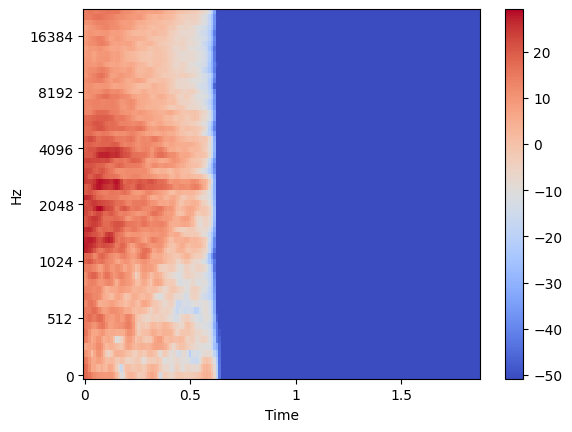

('/Users/matthewharris/Development/neural/drum_classifier/audio/training/08_tambourine/Tambourine 707 SP1200.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/04_ohh/OH CR78 Mod 05.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/06_tom/Tom 2600 01.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/09_cymbal/Ride S612 Glitch 02.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/04_ohh/OH MPC60 Short 01.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/06_tom/Tom 808 Sat Mid 03.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/01_snare_drum/SD S612 Classic.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/06_tom/Tom DMX Color B Mid 01.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio/training/01_snare_drum/SD DX Clean 03.wav', '/Users/matthewharris/Development/neural/drum_clas

In [10]:
# Test the prediction on a sample from the validation data
# TODO: This should become a proper looping validation step - not just looking
#       examples one by one!
first = next(it)

with torch.no_grad():
    inputs, labels, path = first[0].to(device), first[1].to(device), first[2]

    inputs_m, inputs_std = inputs.mean(), inputs.std()
    norm_input = (inputs - inputs_m) / inputs_std

    outputs = model(norm_input)

    print(outputs[0].shape)
    print(outputs[0], labels[0])

spec = transforms.AmplitudeToDB(top_db=80)(inputs[0][0])
plt.figure()
librosa.display.specshow(spec.cpu().numpy(), sr=sr, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show()

print(path)

In [11]:
Audio(path[0])

tensor([[ 1.3640, -1.9996, -3.0201, -0.4089, -1.8108,  0.0899,  8.4331,  2.6912,
          0.7841, -0.1964]])
tensor(6)


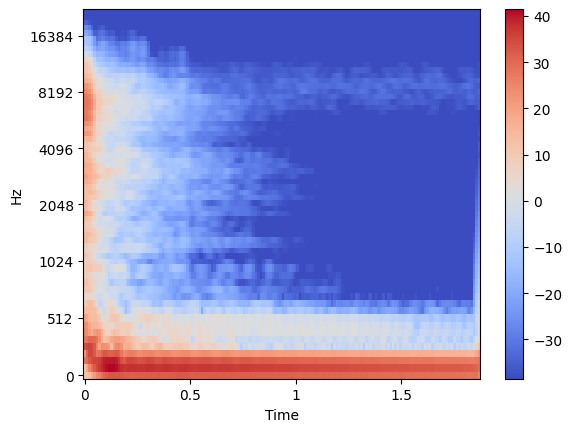

In [80]:
# Test signal example
# TODO: Don't have access to the mean / std deviation from the training to
#       normalise with. This should be extracted / recalculated...

TEST_DIR = os.path.join(CURRENT_DIR, "audio/test")

audio_path = os.path.join(TEST_DIR, "low_tom_01.wav")

signal, sr = AudioUtils.open(audio_path)
signal = AudioUtils.convert_mono(signal)
signal = AudioUtils.resize(signal, desired_sample_len)

mel_spectrogram = AudioUtils.get_mel_spectrogram(signal, 44100, hop_length=128, n_mels=64)

with torch.no_grad():
    model.eval()
    inputs = mel_spectrogram.to(device)
    outputs = model(inputs.unsqueeze(0))

    print(outputs)
    print(torch.argmax(outputs))

spec = transforms.AmplitudeToDB(top_db=80)(mel_spectrogram[0])
plt.figure()
librosa.display.specshow(spec.cpu().numpy(), sr=sr, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show()